# Testing assumptions about data shape and model choice

## Things we want to test

1. Are classifiers or regressors more accurate?
    * Regressors are more convenient due to margin-picking tie-breaker


2. Does it make a difference organising data by match (each match = 1 row) or team match (each match = 2 rows, 1 per participating team)?
    * Team match is more convenient for calculating secondary features and reduces number of columns while doubling number of rows, which can help with Curse of Dimensionality, but splits the key observation (the match) into two that have to be combined later.


3. Which metric is better for model evaluation?
    * [Matter of Stats](http://www.matterofstats.com/mafl-stats-journal/2018/5/17/accuracy-versus-mae-for-assessing-forecaster-ability-in-a-finite-season) suggests that evaluating on, and optimising to, mean absolute error is better than accuracy (perhaps using log loss instead of accuracy for a classifier?), because it is more consistent in identifying the best model.

In [1]:
# Python modules
import dateutil
from datetime import datetime
import re

# Data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit Learn utility classes & functions
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

# Scikit Learn models
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, ElasticNet, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Our own code
from src.data.data_builder import DataBuilder, BettingData, MatchData
from src.data.data_transformer import DataTransformer
from src.data.feature_builder import FeatureBuilder
from src.model.metrics import measure_estimators

np.random.seed(42)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
csv_paths = ('data/afl_betting.csv', 'data/ft_match_list.csv')
data_classes = (BettingData, MatchData)

raw_df = DataBuilder(data_classes, csv_paths).concat()
transformer = DataTransformer(raw_df)
model_df = transformer.clean()
model_df

,home_team,away_team,home_win_odds,home_line_odds,away_win_odds,away_line_odds,home_score,away_score,round_number,year
0,Richmond,Carlton,2.89,16.5,1.42,-16.5,64.0,120.0,1,2010
1,Geelong,Essendon,1.21,-28.5,4.50,28.5,125.0,94.0,1,2010
2,Sydney,St Kilda,2.64,14.5,1.49,-14.5,88.0,96.0,1,2010
3,Brisbane,West Coast,1.32,-21.5,3.42,21.5,114.0,82.0,1,2010
4,Melbourne,Hawthorn,4.95,31.5,1.18,-31.5,61.0,117.0,1,2010
5,Port Adelaide,North Melbourne,1.42,-16.5,2.89,16.5,96.0,82.0,1,2010
6,Fremantle,Adelaide,1.96,1.5,1.85,-1.5,118.0,62.0,1,2010
7,Western Bulldogs,Collingwood,1.62,-8.5,2.31,8.5,93.0,129.0,1,2010
8,Brisbane,Carlton,1.34,-19.5,3.30,19.5,107.0,88.0,2,2010
9,West Coast,Port Adelaide,1.63,-10.5,2.30,10.5,86.0,89.0,2,2010


## Which is better for our task, classifiers or regressors?

In [3]:
model_features = pd.get_dummies(model_df.drop(['home_score', 'away_score'], axis=1))
model_labels = pd.DataFrame({'home_win': (model_df['home_score'] >= model_df['away_score']).astype(int),
                             'home_score_diff': model_df['home_score'] - model_df['away_score']})
X_train, X_test, y_train, y_test = train_test_split(model_features, model_labels)

In [4]:
# First we try some basic classifiers

# Just using basic, mostly linear, models to validate some ideas around how to shape the data & optimise.
# Throwing in RandomForest to get a data point for ensemble models.
classifiers = (LogisticRegression(),
              RidgeClassifier(),
              DecisionTreeClassifier(),
              LinearSVC(),
              KNeighborsClassifier(),
              RandomForestClassifier())
data = (X_train, X_test, y_train['home_win'], y_test['home_win'])

classifier_scores = measure_estimators(classifiers, data, model_type='classification')



LogisticRegression
Mean CV accuracy: 0.6864397838939806
Test accuracy: 0.7146892655367232

Mean CV negative error score: -0.57188686631313
Test error score: 9.85438304568618


RidgeClassifier
Mean CV accuracy: 0.698717473999561
Test accuracy: 0.7090395480225988

Mean CV negative error score: NA
Test error score: NA


DecisionTreeClassifier
Mean CV accuracy: 0.6214600128716501
Test accuracy: 0.6638418079096046

Mean CV negative error score: -12.879570340854183
Test error score: 11.610607826167545


LinearSVC
Mean CV accuracy: 0.6949483181841654
Test accuracy: 0.711864406779661

Mean CV negative error score: NA
Test error score: NA


KNeighborsClassifier
Mean CV accuracy: 0.6780334545350736
Test accuracy: 0.6384180790960452

Mean CV negative error score: -1.7130456043623656
Test error score: 12.488730380782341


RandomForestClassifier
Mean CV accuracy: 0.6666414145548722
Test accuracy: 0.7090395480225988

Mean CV negative error score: -1.5420807963915035
Test error score: 10.0495151168

In [5]:
# Next we try some basic regressors

# Just using basic, mostly linear, models to validate some ideas around how to shape the data & optimise.
# Throwing in RandomForest to get a data point for ensemble models
regressors = (Lasso(), ElasticNet(), Ridge(), LinearSVR(), RandomForestRegressor())
data = (X_train, X_test, y_train['home_score_diff'], y_test['home_score_diff'])

regressor_scores = measure_estimators(regressors, data, model_type='regression')



Lasso
Mean CV accuracy: 0.7184648773141997
Test accuracy: 0.7429378531073446

Mean CV negative error score: 29.275820254972786
Test error score: 28.037462163696947


ElasticNet
Mean CV accuracy: 0.7147090087695986
Test accuracy: 0.7344632768361582

Mean CV negative error score: 29.458340675540846
Test error score: 27.9109250926385


Ridge
Mean CV accuracy: 0.7071618389582779
Test accuracy: 0.7372881355932204

Mean CV negative error score: 29.949745586306488
Test error score: 28.5451198665939


LinearSVR
Mean CV accuracy: 0.7024315705554078
Test accuracy: 0.7344632768361582

Mean CV negative error score: 30.486634157362964
Test error score: 28.40054301572243


RandomForestRegressor
Mean CV accuracy: 0.6902117105146603
Test accuracy: 0.6949152542372882

Mean CV negative error score: 32.50320710426079
Test error score: 31.673728813559322


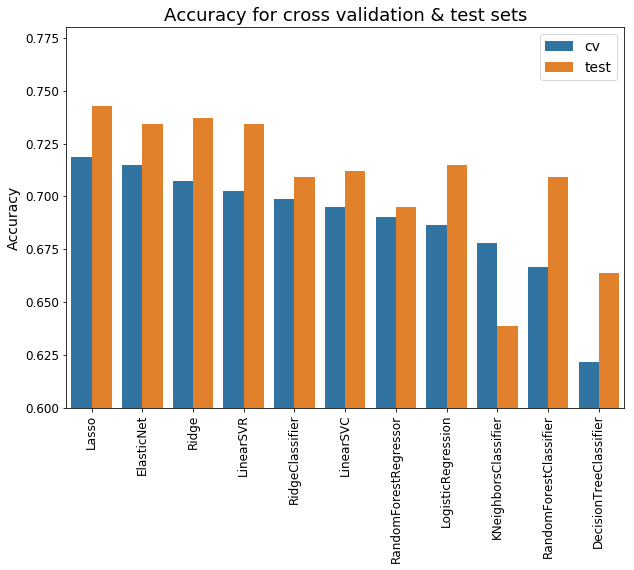

In [6]:
# Accuracy scores
acc_scores = classifier_scores.append(regressor_scores).sort_values(['score_type', 'accuracy'], ascending=[True, False])

plt.figure(figsize=(10, 7))
sns.barplot(x='estimator', y='accuracy', hue='score_type', data=acc_scores)
plt.ylim(ymin=0.60)
plt.title('Accuracy for cross validation & test sets', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

### Linear regressors perform a little better than linear classifiers

Having played around with this over many different runs, classifiers sometimes get slightly better accuracy, but regressors tend to be better on cross validation, only sometimes over-fitting the data and getting worse performance than classifiers on the test set. Also, regressors are more convenient to use for predictions, because I'll need to predict score differentials for the tipping competition. So, I'll approach this as a regression problem and thus narrow down my tuning options by limiting the available algorithms. It's not super important, but the squiggle.com.au tipping competition requires models to predict margins on all matches, so if I want to compare myself to the best, I'll have to do the same.

## Use match rows or team-match rows?

In [7]:
# Reshape model_df to split each match into 2 rows: 1 per participating team

team_df = DataTransformer(raw_df).stack_teams()
team_df

team         oppo_team  \
team             year round_number                                       
Adelaide         2010 1                     Adelaide         Fremantle   
                      2                     Adelaide            Sydney   
                      3                     Adelaide         Melbourne   
                      4                     Adelaide           Carlton   
                      5                     Adelaide  Western Bulldogs   
                      6                     Adelaide     Port Adelaide   
                      7                     Adelaide          Richmond   
                      8                     Adelaide   North Melbourne   
                      9                     Adelaide          Brisbane   
                      10                    Adelaide          St Kilda   
                      11                    Adelaide         Fremantle   
                      12                    Adelaide          Hawthorn   
                      13                    Adelaide         Melbourne   
                      14                    Adelaide          Essendon   
                      15                    Adelaide        West Coast   
                      16                    Adelaide           Geelong   
                      17                    Adelaide     Port Adelaide   
                      18                    Adelaide          Richmond   
                      19                    Adelaide  Western Bulldogs   
                      20                    Adelaide          Brisbane   
                      21                    Adelaide       Collingwood   
                      22                    Adelaide          St Kilda   
                 2011 1                     Adelaide          Hawthorn   
                      3                     Adelaide         Fremantle   
                      4                     Adelaide     Port Adelaide   
                      5                     Adelaide           Carlton   
                      6                     Adelaide          St Kilda   
                      7                     Adelaide         Melbourne   
                      8                     Adelaide        Gold Coast   
                      9                     Adelaide       Collingwood   
...                                              ...               ...   
Western Bulldogs 2015 21            Western Bulldogs        West Coast   
                      22            Western Bulldogs   North Melbourne   
                      23            Western Bulldogs          Brisbane   
                      25            Western Bulldogs          Adelaide   
                 2016 1             Western Bulldogs         Fremantle   
                      2             Western Bulldogs          St Kilda   
                      3             Western Bulldogs          Hawthorn   
                      4             Western Bulldogs           Carlton   
                      5             Western Bulldogs          Brisbane   
                      6             Western Bulldogs   North Melbourne   
                      7             Western Bulldogs          Adelaide   
                      8             Western Bulldogs         Melbourne   
                      9             Western Bulldogs               GWS   
                      10            Western Bulldogs       Collingwood   
                      11            Western Bulldogs        West Coast   
                      12            Western Bulldogs     Port Adelaide   
                      13            Western Bulldogs           Geelong   
                      15            Western Bulldogs            Sydney   
                      16            Western Bulldogs          Richmond   
                      17            Western Bulldogs        Gold Coast   
                      18            Western Bulldogs          St Kilda   
                      19            Western Bulldogs

In [8]:
team_features = pd.get_dummies(team_df.drop(['score', 'oppo_score'], axis=1))
team_labels = pd.Series(team_df['score'] - team_df['oppo_score'], name='score_diff')
data = train_test_split(team_features, team_labels)
                        
estimator_scores = measure_estimators(regressors, data, model_type='regression')



Lasso
Mean CV accuracy: 0.7252463928967813
Test accuracy: 0.7161016949152542

Mean CV negative error score: 29.053149638160285
Test error score: 28.153125591205004


ElasticNet
Mean CV accuracy: 0.7290244173140955
Test accuracy: 0.7161016949152542

Mean CV negative error score: 29.272162592916487
Test error score: 28.19800208803977


Ridge
Mean CV accuracy: 0.7266703662597115
Test accuracy: 0.7217514124293786

Mean CV negative error score: 29.234096831041512
Test error score: 28.248283229323604


LinearSVR
Mean CV accuracy: 0.721488346281909
Test accuracy: 0.7217514124293786

Mean CV negative error score: 29.508115106880986
Test error score: 27.988645704939124


RandomForestRegressor
Mean CV accuracy: 0.6875438401775804
Test accuracy: 0.692090395480226

Mean CV negative error score: 32.22463817980023
Test error score: 31.259463276836154


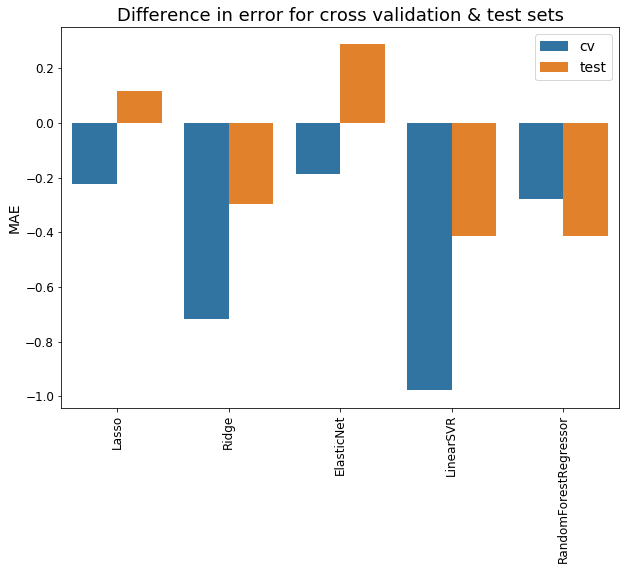

In [9]:
# Accuracy scores

comparison = (estimator_scores.assign(error_diff=estimator_scores['error'] - regressor_scores['error'])
                              .sort_values(['score_type', 'error'], ascending=[True, True]))

plt.figure(figsize=(10, 7))
sns.barplot(x='estimator', y='error_diff', hue='score_type', data=comparison)
plt.title('Difference in error for cross validation & test sets', fontsize=18)
plt.ylabel('MAE', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

### Organising data by team-matches has slightly positive impact on performance

It's close enough that it can vary by data split, but since this organisation is necessary for cumulative features, this is potentially more convenient, but it may require an extra step when measuring performance to make sure two opponents aren't predicted to win, resulting in 50% accuracy rather than 0% or 100% per match.